# 1.0. Problem Definition

The National Diabetes Statistics Report identified that about 1 in 10 Americans have diabetes, and 1 in 3 have prediabetes. Diabetes occurs when the body does not make or utilize enough insulin for the body to be able to digest sugar into energy. People with Type 1 diabetes require taking insulin shots every day, but people with Type 2 and prediabetes may be able to prevent Type 1 diabetes with a change of lifestyle or better diet habits. Early detection is critical for those with Type 2 and prediabetes in order to curb the risk of Type 1 diabetes. This notebook aims to create a model that takes in various information about participants in the NHANES survey to determine if they have or at risk of having diabetes. 

In this specific notebook, we gather and import our initial data, do some data exploration, add additional attributes, create a pipeline for our attributes, and train a SGD Classifier on our data before evaluating on the test set.

# 2.0. Data Gathering and Import

In [65]:
# Import all packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix



## 2.1. Gathering and Importing Data

In [66]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/"
# DOWNLOAD_ROOT = "https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017"
LOCAL_DATA_PATH = os.path.join("datasets", "nhanes") + "/"
FILE_NAME = "P_DEMO.XPT"

def fetch_nhanes_data(file_name=FILE_NAME, nhanes_url=DOWNLOAD_ROOT,  nhanes_path=LOCAL_DATA_PATH):
    os.makedirs(nhanes_path, exist_ok=True)
    xpt_path = os.path.join(nhanes_path, file_name)
    url = nhanes_url + file_name
    urllib.request.urlretrieve(url, xpt_path)

In [67]:
# Demographics Data (DEMO_J) : ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2']
fetch_nhanes_data("DEMO_J.XPT")
# Examination Data (BMX_J) : ['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']
fetch_nhanes_data("BMX_J.XPT")
# Questionnaire Data (DIQ_J) : ['SEQN', 'DIQ010']
fetch_nhanes_data("DIQ_J.XPT") # Diabetes dataset
# Laboratory Data : (GLU_J) :   ['SEQN', 'LBXGLU']
fetch_nhanes_data("GLU_J.XPT") # Plasma Fasting Glucose dataset

In [68]:
!ls $LOCAL_DATA_PATH

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [69]:
demo_df = pd.read_sas(LOCAL_DATA_PATH + "DEMO_J.XPT")
bmx_df = pd.read_sas(LOCAL_DATA_PATH + "BMX_J.XPT")
diq_df = pd.read_sas(LOCAL_DATA_PATH + "DIQ_J.XPT")
glu_df = pd.read_sas(LOCAL_DATA_PATH + "GLU_J.XPT")

## 2.2. Exploring Data Structure and Features
Before performing data analysis, we often need to know the structure of our data. Therefore, we perform the following:
- Viewing a small part of our datasets
- Viewing data shape
- Describing the features contained in the datasets

In [70]:
bmx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8704 non-null   float64
 1   BMDSTATS  8704 non-null   float64
 2   BMXWT     8580 non-null   float64
 3   BMIWT     416 non-null    float64
 4   BMXRECUM  894 non-null    float64
 5   BMIRECUM  24 non-null     float64
 6   BMXHEAD   194 non-null    float64
 7   BMIHEAD   0 non-null      float64
 8   BMXHT     8016 non-null   float64
 9   BMIHT     99 non-null     float64
 10  BMXBMI    8005 non-null   float64
 11  BMXLEG    6703 non-null   float64
 12  BMILEG    334 non-null    float64
 13  BMXARML   8177 non-null   float64
 14  BMIARML   347 non-null    float64
 15  BMXARMC   8173 non-null   float64
 16  BMIARMC   350 non-null    float64
 17  BMXWAIST  7601 non-null   float64
 18  BMIWAIST  437 non-null    float64
 19  BMXHIP    6039 non-null   float64
 20  BMIHIP    270 non-null    floa

In [71]:
demo_df.info()
demo_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      9254 non-null   float64
 1   SDDSRVYR  9254 non-null   float64
 2   RIDSTATR  9254 non-null   float64
 3   RIAGENDR  9254 non-null   float64
 4   RIDAGEYR  9254 non-null   float64
 5   RIDAGEMN  597 non-null    float64
 6   RIDRETH1  9254 non-null   float64
 7   RIDRETH3  9254 non-null   float64
 8   RIDEXMON  8704 non-null   float64
 9   RIDEXAGM  3433 non-null   float64
 10  DMQMILIZ  6004 non-null   float64
 11  DMQADFC   561 non-null    float64
 12  DMDBORN4  9254 non-null   float64
 13  DMDCITZN  9251 non-null   float64
 14  DMDYRSUS  1948 non-null   float64
 15  DMDEDUC3  2306 non-null   float64
 16  DMDEDUC2  5569 non-null   float64
 17  DMDMARTL  5569 non-null   float64
 18  RIDEXPRG  1110 non-null   float64
 19  SIALANG   9254 non-null   float64
 20  SIAPROXY  9254 non-null   floa

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,93703.0,10.0,2.0,2.0,2.0,NaN,5.0,6.0,2.0,27.0,...,3.0,1.0,3.0,9246.491865,8539.731348,2.0,145.0,15.0,15.0,5.00
1,93704.0,10.0,2.0,1.0,2.0,NaN,3.0,3.0,1.0,33.0,...,3.0,1.0,2.0,37338.768343,42566.614750,1.0,143.0,15.0,15.0,5.00
2,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
3,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
4,93707.0,10.0,2.0,1.0,13.0,NaN,5.0,7.0,2.0,158.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88


In [72]:
diq_df.describe()

,SEQN,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,...,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
count,8897.000000,8897.000000,892.000000,5694.000000,5876.000000,5876.000000,1145.000000,657.0,217.0,488.0,...,884.000000,886.000000,886.000000,885.000000,831.000000,8.820000e+02,8.820000e+02,712.000000,885.000000,885.000000
mean,98333.855794,1.923457,61.167040,1.904988,1.858918,1.818074,10.155459,11.0,12.0,13.0,...,3382.943439,4466.420993,4667.259594,8101.992090,7652.305656,8.184921e+01,2.399660e+01,1.561798,2.572881,1.865537
std,2671.896914,0.370457,103.045249,0.405824,0.532204,0.903753,3.718026,0.0,0.0,0.0,...,4675.411040,4061.872248,4107.656640,3675.099969,3176.417258,8.875388e+02,4.758125e+02,0.814151,1.255102,0.789495
min,93703.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,11.0,12.0,13.0,...,30.000000,72.000000,30.000000,8.000000,15.000000,5.397605e-79,5.397605e-79,1.000000,1.000000,1.000000
25%,96017.000000,2.000000,40.750000,2.000000,2.000000,1.000000,10.000000,11.0,12.0,13.0,...,72.000000,120.000000,80.000000,9999.000000,6666.000000,5.397605e-79,1.000000e+00,1.000000,2.000000,2.000000
50%,98348.000000,2.000000,50.000000,2.000000,2.000000,2.000000,10.000000,11.0,12.0,13.0,...,81.500000,6666.000000,6666.000000,9999.000000,9999.000000,2.000000e+00,1.000000e+00,1.000000,2.000000,2.000000
75%,100645.000000,2.000000,60.000000,2.000000,2.000000,2.000000,10.000000,11.0,12.0,13.0,...,9999.000000,6666.000000,6666.000000,9999.000000,9999.000000,3.000000e+00,1.000000e+00,2.000000,3.000000,2.000000
max,102956.000000,9.000000,999.000000,9.000000,9.000000,9.000000,99.000000,11.0,12.0,13.0,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9.999000e+03,9.999000e+03,4.000000,9.000000,9.000000


### Keep only relevant columns

In [73]:
# ID number, age, gender, ethnicity, education, income
keep_columns = ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2']
demo_sub_df = demo_df[keep_columns]
demo_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      9254 non-null   float64
 1   RIDAGEYR  9254 non-null   float64
 2   RIAGENDR  9254 non-null   float64
 3   RIDRETH1  9254 non-null   float64
 4   DMDEDUC2  5569 non-null   float64
 5   INDHHIN2  8763 non-null   float64
dtypes: float64(6)
memory usage: 433.9 KB


In [74]:
# ID number, height, waist, bmi, weight, leg measurement
keep_columns = ['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']
bmx_sub_df = bmx_df[keep_columns]
bmx_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8704 non-null   float64
 1   BMXHT     8016 non-null   float64
 2   BMXWAIST  7601 non-null   float64
 3   BMXBMI    8005 non-null   float64
 4   BMXWT     8580 non-null   float64
 5   BMXLEG    6703 non-null   float64
dtypes: float64(6)
memory usage: 408.1 KB


In [75]:
# ID number, diabetes diagnosis
keep_columns = ['SEQN', 'DIQ010']
diq_sub_df = diq_df[keep_columns]
diq_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    8897 non-null   float64
 1   DIQ010  8897 non-null   float64
dtypes: float64(2)
memory usage: 139.1 KB


In [76]:
# ID number, glucose fasting levels
keep_columns = ['SEQN', 'LBXGLU']
glu_sub_df = glu_df[keep_columns]
glu_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    3036 non-null   float64
 1   LBXGLU  2891 non-null   float64
dtypes: float64(2)
memory usage: 47.6 KB


### Merge the datatables into a single table

In [77]:
db_df = demo_sub_df.merge(bmx_sub_df, how='inner', on='SEQN')
db_df = db_df.merge(diq_sub_df,how="inner", on='SEQN')
db_df = db_df.merge(glu_sub_df,how="inner", on='SEQN')
db_df.shape

(3036, 13)

In [78]:
# Note the missing values
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      3036 non-null   float64
 1   RIDAGEYR  3036 non-null   float64
 2   RIAGENDR  3036 non-null   float64
 3   RIDRETH1  3036 non-null   float64
 4   DMDEDUC2  2541 non-null   float64
 5   INDHHIN2  2897 non-null   float64
 6   BMXHT     2985 non-null   float64
 7   BMXWAIST  2869 non-null   float64
 8   BMXBMI    2981 non-null   float64
 9   BMXWT     2984 non-null   float64
 10  BMXLEG    2855 non-null   float64
 11  DIQ010    3036 non-null   float64
 12  LBXGLU    2891 non-null   float64
dtypes: float64(13)
memory usage: 308.5 KB


In [79]:
if ('SEQN' in db_df.columns) :
            db_df = db_df.drop(columns=['SEQN'],axis=1)

### HW: Eliminate individuals 20 and younger (we are focusing primarily on type 2 diabetes)

In [80]:
db_df = db_df[db_df['RIDAGEYR'] > 20]
db_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2502 entries, 0 to 3035
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RIDAGEYR  2502 non-null   float64
 1   RIAGENDR  2502 non-null   float64
 2   RIDRETH1  2502 non-null   float64
 3   DMDEDUC2  2502 non-null   float64
 4   INDHHIN2  2383 non-null   float64
 5   BMXHT     2459 non-null   float64
 6   BMXWAIST  2353 non-null   float64
 7   BMXBMI    2455 non-null   float64
 8   BMXWT     2458 non-null   float64
 9   BMXLEG    2341 non-null   float64
 10  DIQ010    2502 non-null   float64
 11  LBXGLU    2398 non-null   float64
dtypes: float64(12)
memory usage: 254.1 KB


### HW: Develop a reasonable scheme for filling in missing values

In [81]:
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
BMXLEG,161,6.434852
BMXWAIST,149,5.955236
INDHHIN2,119,4.756195
LBXGLU,104,4.156675
BMXBMI,47,1.878497
BMXWT,44,1.758593
BMXHT,43,1.718625
RIDAGEYR,0,0.000000
RIAGENDR,0,0.000000
RIDRETH1,0,0.000000


In [82]:
db_df = db_df[db_df['LBXGLU'].notna()].reset_index(drop=True)
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
BMXLEG,140,5.838198
BMXWAIST,124,5.170976
INDHHIN2,110,4.587156
BMXBMI,41,1.709758
BMXWT,39,1.626355
BMXHT,38,1.584654
RIDAGEYR,0,0.000000
RIAGENDR,0,0.000000
RIDRETH1,0,0.000000
DMDEDUC2,0,0.000000


In [83]:
# List of columns to calculate the average for
columns = ['INDHHIN2', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG', 'DMDEDUC2']

# Calculate the average for each column
averages = db_df[columns].mean()
medians = db_df[columns].median()
modes = db_df[columns].mode()

# Print the averages
print(averages)
print(medians)
print(modes)

INDHHIN2     12.816871
BMXHT       166.397288
BMXWAIST    100.728584
BMXBMI       29.850742
BMXWT        82.893090
BMXLEG       38.958769
DMDEDUC2      3.504170
dtype: float64
INDHHIN2      9.00
BMXHT       166.05
BMXWAIST     99.10
BMXBMI       28.50
BMXWT        79.50
BMXLEG       39.00
DMDEDUC2      4.00
dtype: float64
   INDHHIN2  BMXHT  BMXWAIST  BMXBMI  BMXWT  BMXLEG  DMDEDUC2
0      15.0  166.8      94.0    27.8   71.0    39.0       4.0
1       NaN    NaN     107.2     NaN    NaN     NaN       NaN


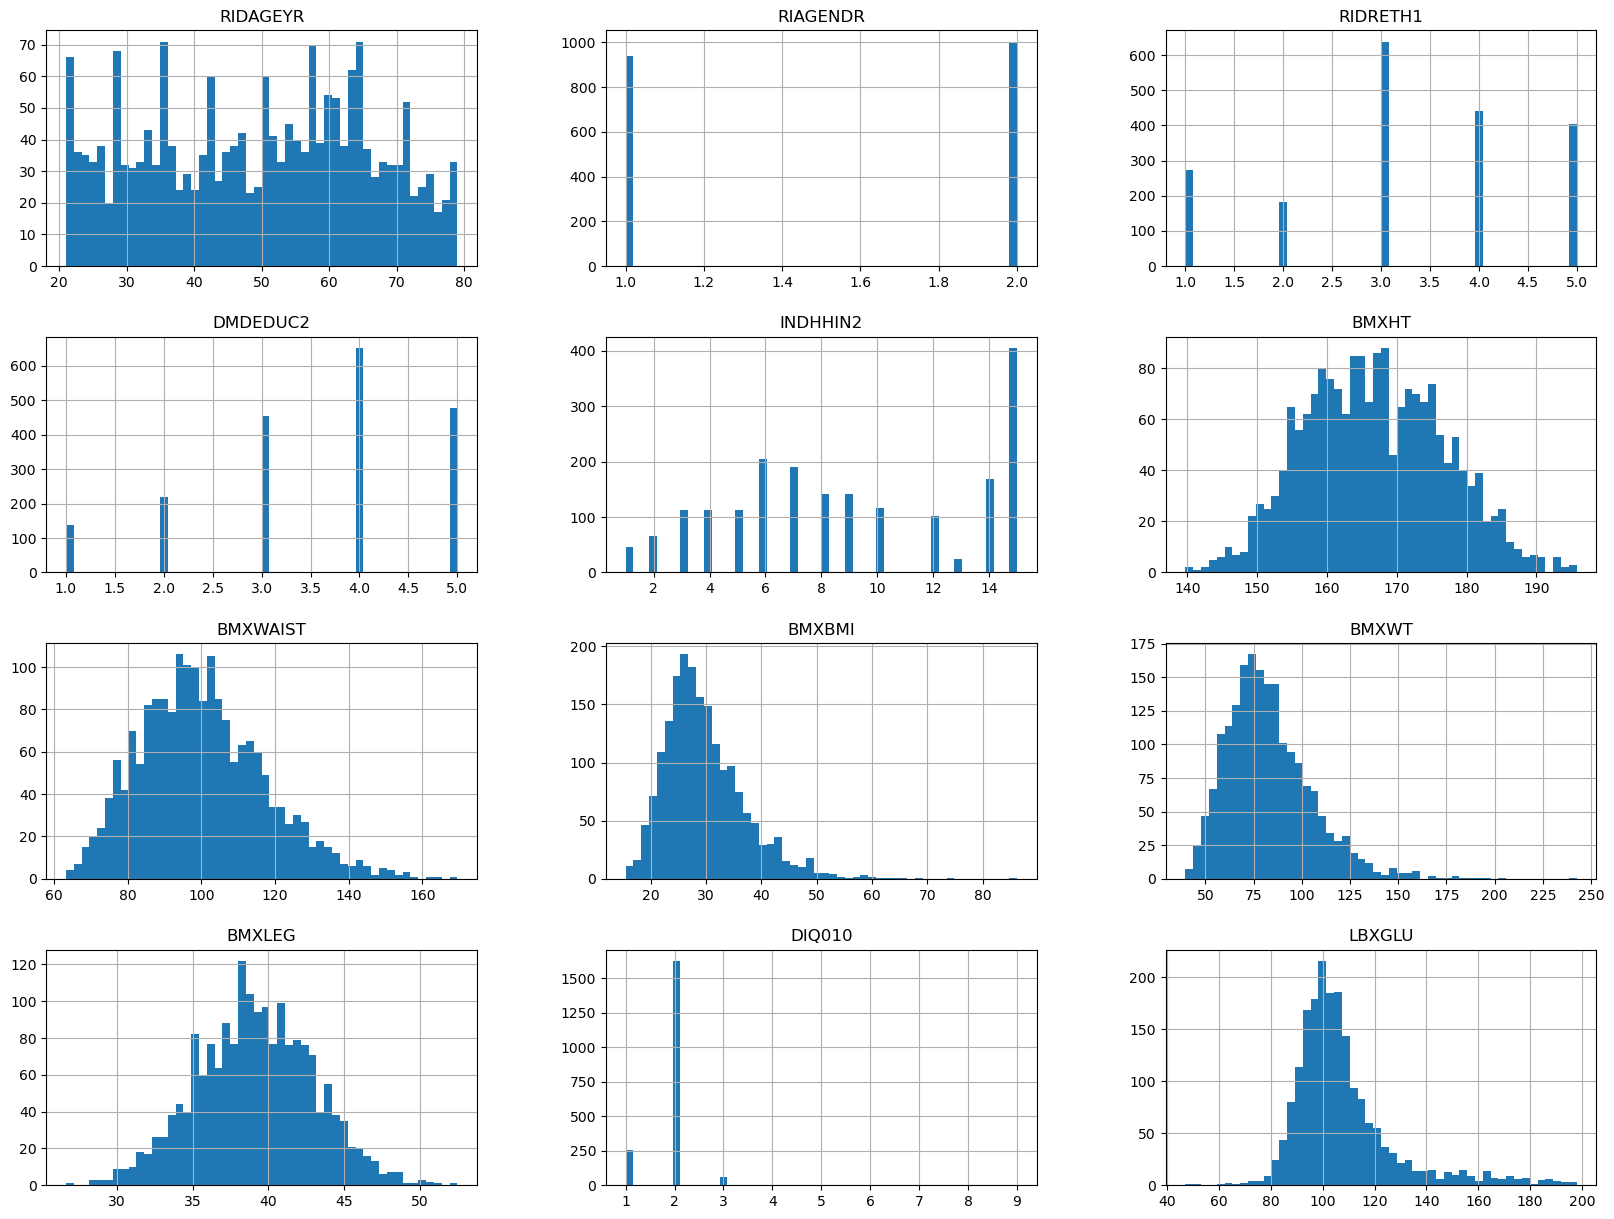

In [84]:
graphs = db_df
# Restrict graphs so that we aren't viewing outliers
graphs = graphs[graphs['RIDAGEYR'] < 80]
graphs = graphs[graphs['INDHHIN2'] < 60]
graphs = graphs[graphs['LBXGLU'] < 200]
graphs.hist(bins=50, figsize=(20,15))
plt.show()

### HW: Justification

In [85]:
# Null values in
# INDHHIN2 = Annual household income - we'll use fill-forward for this one
db_df['INDHHIN2'].fillna(method='ffill', inplace=True)
# ALL BMX values: - we'll use medians for these
#   - BMXHT = Standing Height (cm)
#   - BMXWAIST = Waist Circumference (cm)
#   - BMXBMI = Body Mass Index (kg/m**2)
#   - BMXWT = Weight (kg)
#   - BMXLEG = Upper Leg Length (cm)
db_df[['BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']] = db_df[['BMXHT', 'BMXWAIST', 'BMXBMI',
                                                                    'BMXWT', 'BMXLEG']].fillna(db_df[['BMXHT', 'BMXWAIST', 'BMXBMI',
                                                                                                      'BMXWT', 'BMXLEG']].median())

# LBXGLU = fasting glucose level; 99 mg/dL = normal, 100–125 mg/dL = pre-diabetes, 126 mg/dL or above = diabetes
# We'll use mode for LBXGLU, because we don't want to assume that all those w/o LBXGLU values are immediately pre-diabetes or have diabetes

In [86]:
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
RIDAGEYR,0,0.0
RIAGENDR,0,0.0
RIDRETH1,0,0.0
DMDEDUC2,0,0.0
INDHHIN2,0,0.0
BMXHT,0,0.0
BMXWAIST,0,0.0
BMXBMI,0,0.0
BMXWT,0,0.0
BMXLEG,0,0.0


In [87]:
db_df.shape

(2398, 12)

### Develop a pipeline for new attributes, recoding categorical data that is not ordinal, and normalizing numeric data

In [88]:
db_df.dtypes

RIDAGEYR    float64
RIAGENDR    float64
RIDRETH1    float64
DMDEDUC2    float64
INDHHIN2    float64
BMXHT       float64
BMXWAIST    float64
BMXBMI      float64
BMXWT       float64
BMXLEG      float64
DIQ010      float64
LBXGLU      float64
dtype: object

In [89]:
dtype_cols = [col for col in db_df.columns if col not in ['LBXGLU']]

for col in dtype_cols:
    db_df[col] = db_df[col].astype('int')
db_df.dtypes

RIDAGEYR      int32
RIAGENDR      int32
RIDRETH1      int32
DMDEDUC2      int32
INDHHIN2      int32
BMXHT         int32
BMXWAIST      int32
BMXBMI        int32
BMXWT         int32
BMXLEG        int32
DIQ010        int32
LBXGLU      float64
dtype: object

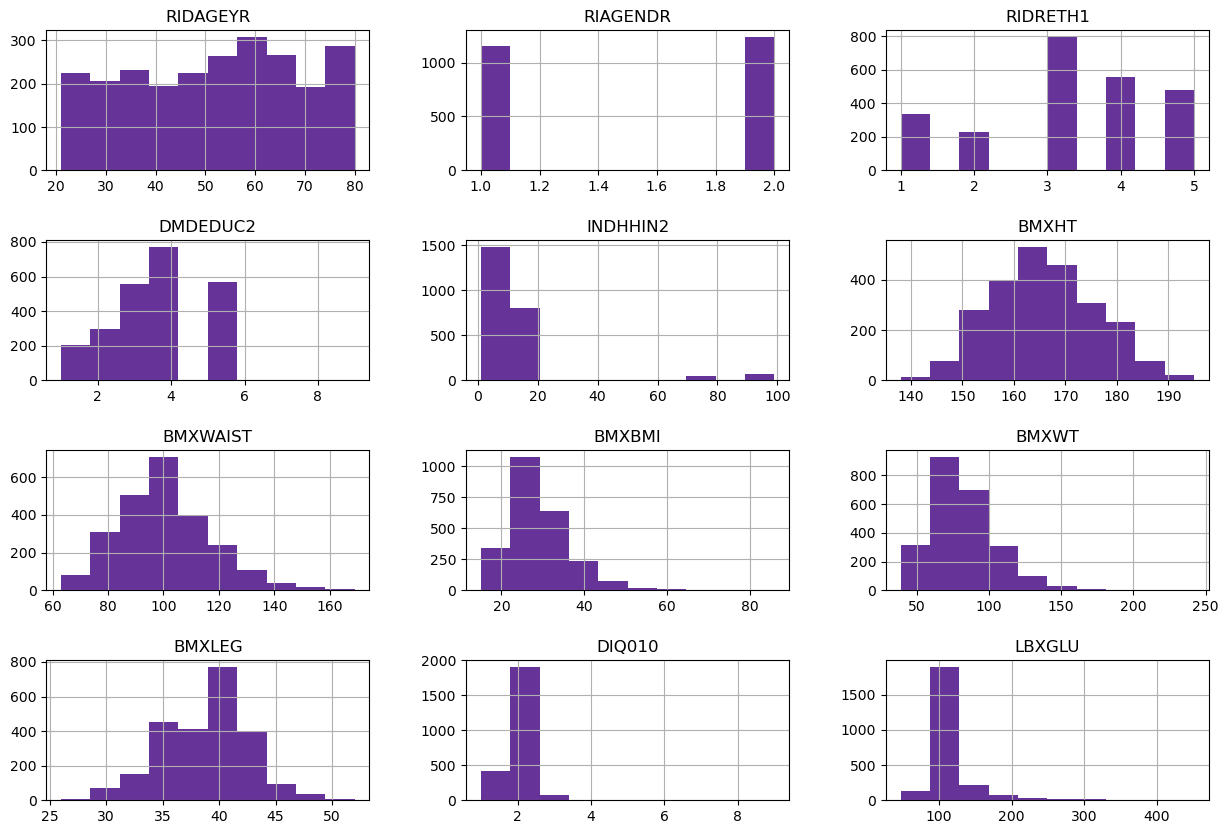

In [90]:
#let's get the histograms to get an idea of their distributions
db_df.hist(figsize=(15, 10), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [91]:
# Function to assist for adding attributes
def diab(fgl, diag):
    if ((fgl > 125) or (diag == 1)):
        return 1
    else:
        return 0

In [92]:
def db_recode_values(db_df):
    #replace the 1(male) from the original dataset to 0 and 2(female) to 1
    db_df['RIAGENDR'].replace({1: 0, 2: 1}, inplace=True)

    #Here 1 to 5 indicates education level at or below college, 7 means refused, and 9 means don't know
    # Replace 7 and 9 by mode(some college or AA degree)
    db_df['DMDEDUC2'].replace({7: 4, 9: 4}, inplace=True)

    # replace 13(under $20,000) by 4($15,000 to $19,999)
    #replace 12(over $20,000), 77(refused) and 99(don't know) by mode($25,000 to $34,999).
    db_df['INDHHIN2'].replace({13: 4, 12: 6, 77: 6, 99: 6}, inplace=True)

    #Here 1 means the individual has been told they have diabetes, 2 means no diabetes, 3 means borderline and 9 stands for refused
    #replace 3 by 1 and 9 by 2
    db_df['DIQ010'].replace({3: 1, 9: 2}, inplace=True)

    return db_df

In [93]:
# These will act as our labels
def db_add_attributes(db_df):
    if ('LBXGLU' in db_df.columns) & ('DIQ010' in db_df.columns) :
       db_df['diabetes_cat'] = db_df.apply(lambda x : diab(x['LBXGLU'], x['DIQ010']), axis=1)
    return db_df

In [94]:
# We don't want labels in our training data
def db_drop_columns(db_df):
        if ('LBXGLU' in db_df.columns) & ('DIQ010' in db_df.columns) :
            db_df = db_df.drop(columns=['LBXGLU','DIQ010'],axis=1)
        return db_df


In [95]:
def db_add_trim__recode_drop(db_df):
    db_df = db_recode_values(db_df)
    db_df = db_add_attributes(db_df)
    db_df = db_drop_columns(db_df)

    return db_df

In [96]:
db_df.head(10)

,RIDAGEYR,RIAGENDR,RIDRETH1,DMDEDUC2,INDHHIN2,BMXHT,BMXWAIST,BMXBMI,BMXWT,BMXLEG,DIQ010,LBXGLU
0,66,2,5,1,6,150,88,23,53,31,3,122.0
1,56,1,5,5,15,170,86,21,62,40,2,107.0
2,22,1,3,3,15,174,86,24,74,44,2,91.0
3,45,1,4,3,10,157,77,22,54,41,2,89.0
4,60,2,1,1,8,154,113,35,85,34,2,104.0
5,60,2,3,4,6,154,89,23,56,34,2,101.0
6,52,1,2,1,2,147,104,35,76,35,2,83.0
7,26,1,2,4,15,170,102,33,97,40,2,102.0
8,72,1,4,5,7,178,115,33,107,40,1,106.0
9,73,2,3,4,14,153,88,25,60,34,2,119.0


In [97]:
db_df = db_add_trim__recode_drop(db_df)
db_df.head(10)

,RIDAGEYR,RIAGENDR,RIDRETH1,DMDEDUC2,INDHHIN2,BMXHT,BMXWAIST,BMXBMI,BMXWT,BMXLEG,diabetes_cat
0,66,1,5,1,6,150,88,23,53,31,1
1,56,0,5,5,15,170,86,21,62,40,0
2,22,0,3,3,15,174,86,24,74,44,0
3,45,0,4,3,10,157,77,22,54,41,0
4,60,1,1,1,8,154,113,35,85,34,0
5,60,1,3,4,6,154,89,23,56,34,0
6,52,0,2,1,2,147,104,35,76,35,0
7,26,0,2,4,15,170,102,33,97,40,0
8,72,0,4,5,7,178,115,33,107,40,1
9,73,1,3,4,14,153,88,25,60,34,0


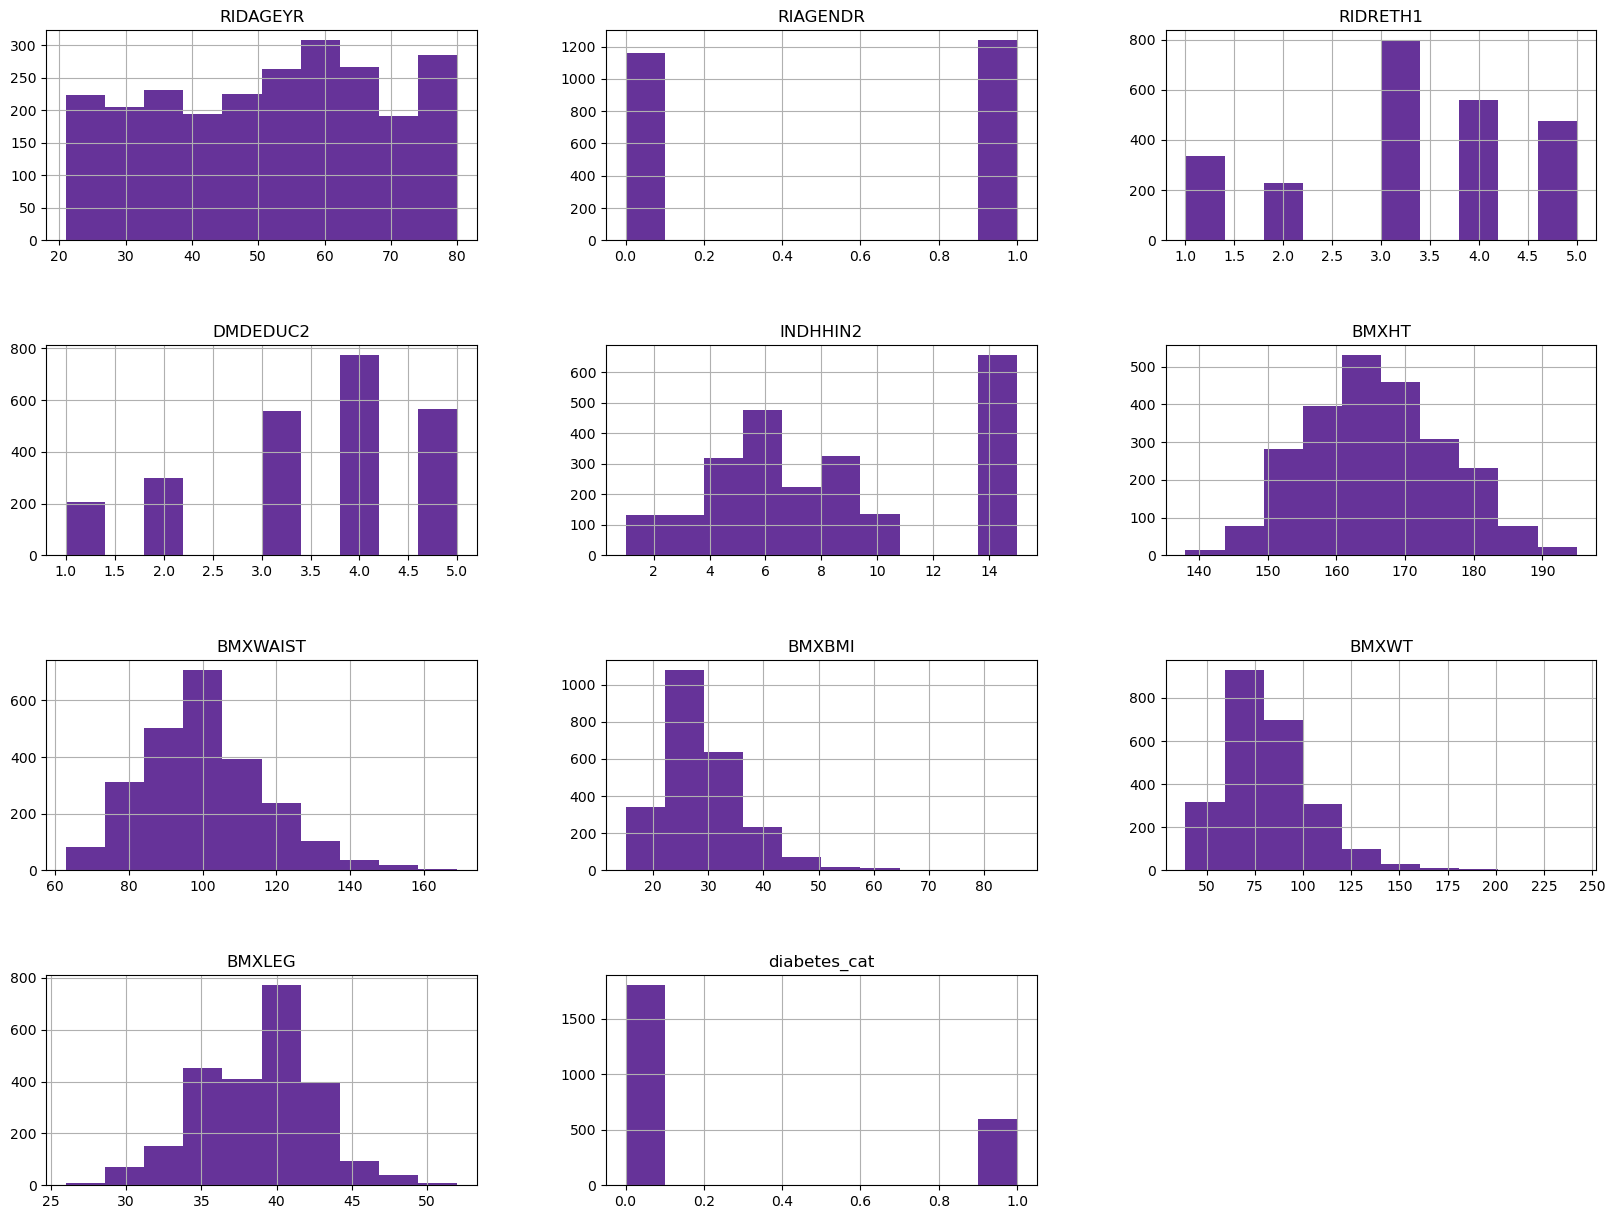

In [98]:
#get the new histograms to get an idea of their distributions
db_df.hist(figsize=(20, 15), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

### More exploratory analysis

In [99]:
y = db_df['diabetes_cat']
X = db_df.drop('diabetes_cat',axis=1)

In [100]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
X_train,  X_val, y_train, y_val = train_test_split(X_train,y_train,  test_size=0.1, random_state=19)

In [101]:
#confirming the ratios of train, test and validation sets for X
print('Percent heldout for training:', round(100*(len(X_train)/len(db_df)),0),'%')
print('Percent heldout for validation', round(100*(len(X_val)/len(db_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(X_test)/len(db_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation 8.0 %
Percent heldout for testing: 20.0 %


In [102]:
#confirming the ratios of train, test and validation sets for y
print('Percent heldout for training:', round(100*(len(y_train)/len(db_df)),0),'%')
print('Percent heldout for validation:', round(100*(len(y_val)/len(db_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(y_test)/len(db_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation: 8.0 %
Percent heldout for testing: 20.0 %


In [103]:
y_train.value_counts(normalize=True)

diabetes_cat
0    0.752607
1    0.247393
Name: proportion, dtype: float64

In [104]:
y_val.value_counts(normalize=True)

diabetes_cat
0    0.75
1    0.25
Name: proportion, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'RIAGENDR'),
  Text(0, 1.5, 'RIDAGEYR'),
  Text(0, 2.5, 'BMXBMI'),
  Text(0, 3.5, 'BMXWAIST'),
  Text(0, 4.5, 'BMXHT'),
  Text(0, 5.5, 'BMXWT'),
  Text(0, 6.5, 'BMXLEG'),
  Text(0, 7.5, 'INDHHIN2'),
  Text(0, 8.5, 'diabetes_cat')])

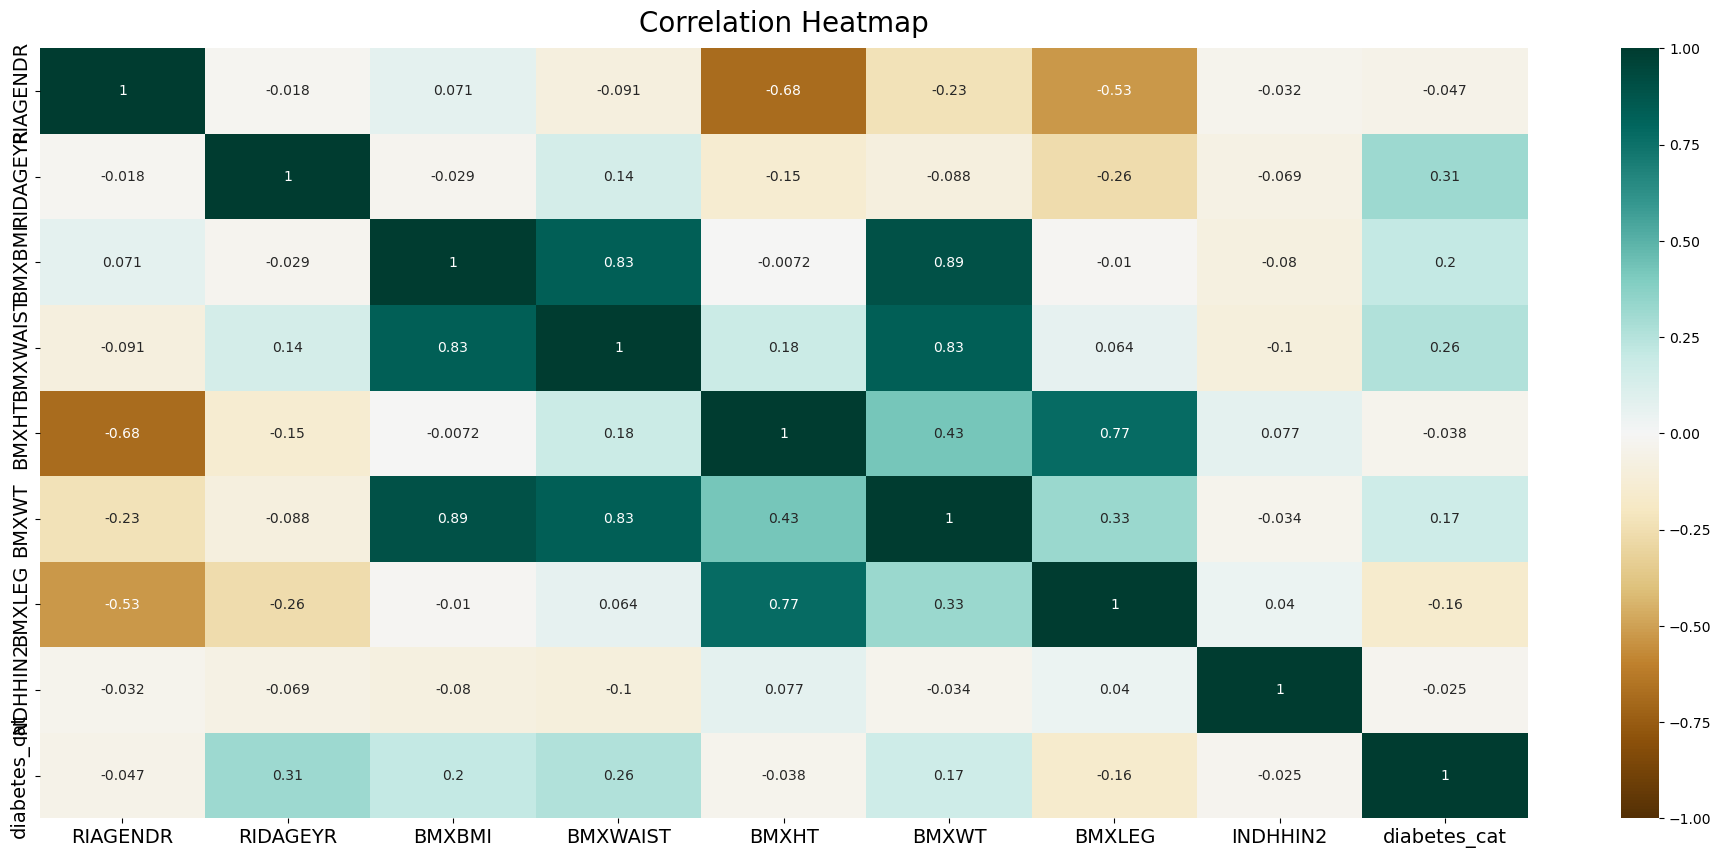

In [105]:
Xy_train = X_train.copy()
Xy_train['diabetes_cat'] = y_train

# Adding heatmaps
corr = Xy_train[['RIAGENDR', 'RIDAGEYR',  'BMXBMI', 'BMXWAIST', 'BMXHT', 'BMXWT', 'BMXLEG', 'INDHHIN2', 'diabetes_cat']].corr()
plt.figure(figsize=(24,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')

In [106]:
X_train.head()

,RIDAGEYR,RIAGENDR,RIDRETH1,DMDEDUC2,INDHHIN2,BMXHT,BMXWAIST,BMXBMI,BMXWT,BMXLEG
852,52,0,3,4,14,182,136,44,149,45
576,57,0,3,4,8,169,123,35,101,38
2175,33,1,4,4,14,161,64,16,42,38
658,53,1,4,4,6,165,126,49,136,39
1341,33,0,3,4,15,181,123,34,115,44


# 3.0 Develop a pipeline and model

## 3.1 Create a pipeline for categorical and numerical attributes

In [107]:
X_train.columns

Index(['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2', 'BMXHT',
       'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG'],
      dtype='object')

In [108]:
num_attribs = ['RIDAGEYR', 'INDHHIN2', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']
cat_attribs = ["RIAGENDR","RIDRETH1", "DMDEDUC2"]

In [109]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])

In [110]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
db_prepared = full_pipeline.fit_transform(X_train)

In [111]:
db_prepared.shape

(1726, 19)

In [112]:
db_prepared[1,0:19]

array([ 0.28564409, -0.07519704,  0.32172335,  1.41349873,  0.7794863 ,
        0.84244858, -0.17471191,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

In [113]:
db_df[cat_attribs].apply(pd.Series.value_counts)

,RIAGENDR,RIDRETH1,DMDEDUC2
0,1159.0,NaN,NaN
1,1239.0,337.0,204.0
2,NaN,227.0,298.0
3,NaN,797.0,557.0
4,NaN,560.0,773.0
5,NaN,477.0,566.0


## 3.2 Use the Stochastic Gradient Descent Classifier to do develop a model on the training data

In [114]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=19)
sgd_clf.fit(db_prepared, y_train)

SGDClassifier(random_state=19)

In [115]:
some_data = db_prepared[5]
some_labels = y_train.iloc[5]
sgd_clf.predict([some_data])

array([0], dtype=int64)

## 3.3 Performance measures

### Accuracy using Cross-Validation
Helps us understand how the model generalizes, rather than how the model does on only one specific training set

In [116]:
cross_val_score(sgd_clf, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.72395833, 0.72521739, 0.76521739])

### Confusion Matrix
Helps us understand where the model is making errors, by showing us when it incorrectly classifies instances. In this case as a binary classifier, it is most useful to see the false-positives and the false-negatives

In [117]:
y_train_pred = cross_val_predict(sgd_clf, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[1168,  131],
       [ 321,  106]], dtype=int64)

### Precision and Recall and F1
Different measurements related to true positive and true negative. This helps us understand in a numerical way how well the model is able to classify generally within the dataset. We use the F1 score to help us evaluate precision and recall (it can also be used as a general measurement for both).

In [118]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.4472573839662447
0.24824355971896955
0.31927710843373497


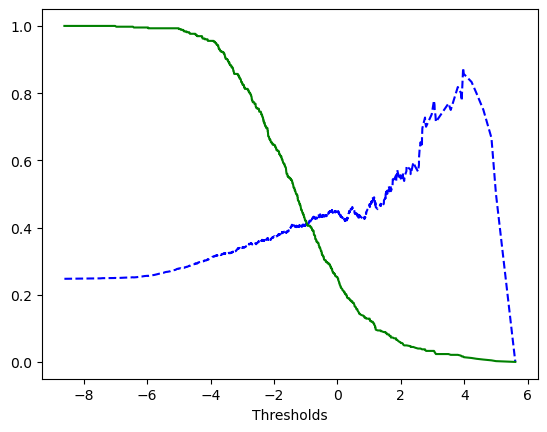

In [119]:
y_scores = cross_val_predict(sgd_clf, db_prepared, y_train, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...]
  # Label the x-axis
  plt.xlabel('Thresholds')


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

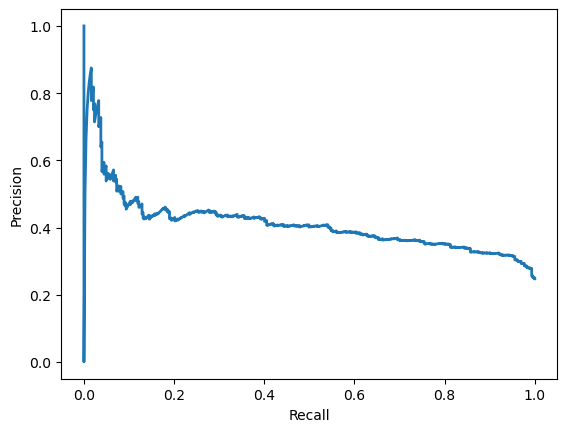

In [120]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, linewidth=2)
  # Label the x-axis and y-axis
  plt.xlabel('Recall')
  plt.ylabel('Precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()

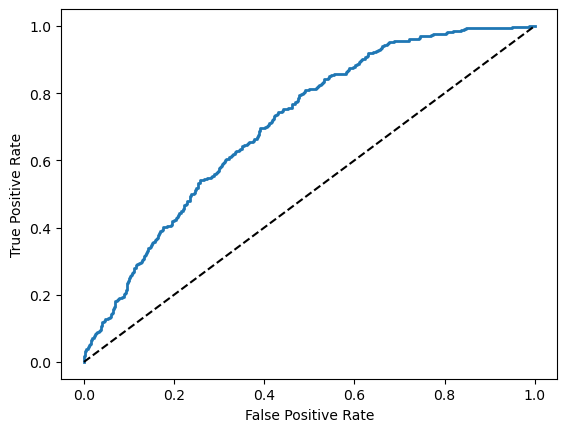

In [121]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  [...]
  # Label the x-axis and y-axis
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


plot_roc_curve(fpr, tpr)
plt.show()

### Whether to use ROC or Precision-Recall Graph
While both graphs have their uses, the ROC graph gives us a better idea of how the model is doing overall. The closer the curve of the ROC graph is to the upper-left corner, generally the better the model is doing. In this case, we can see the model is only doing moderately better than a random model would be (the dashed line).

## Evaluate on test set

In [122]:
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)

array([[299,  61],
       [ 69,  51]], dtype=int64)

In [123]:
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))

0.45535714285714285
0.425
0.43965517241379304


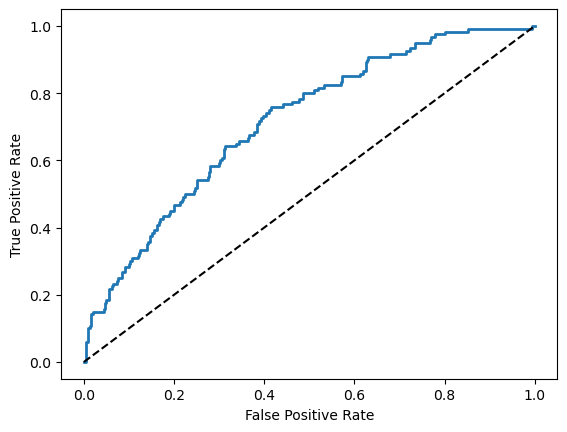

In [125]:
y_scores = cross_val_predict(sgd_clf, X_test, y_test, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  [...]
  # Label the x-axis and y-axis
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


plot_roc_curve(fpr, tpr)
plt.show()

### Evaluation discussion

Our model is doing relatively poor on both the training and test set. This could imply a number of things, but in this case it mostly seems like the model is struggling to learn from the data in order to accurately predict diabetes. This could be because it does not have enough data, because the wrong hyper-parameters were chosen, or too much variance in the dataset. The similar scores between the training and testing sets imply that the model is underfitting, rather than overfitting.

In [124]:
# include references to notebooks you used
# Lab 4
# Lab 5